In [196]:
import numpy as np
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [20]:
sensing_list=[]
for name in os.listdir("./StudentLife_Dataset/Inputs/sensing/"):
    if name.startswith('.'):
        continue
    sensing_list.append(name)

In [228]:
inputs = {}
num_quite={}
for name in sensing_list:
    
    li = []
    p=[]
    for j in range(60):
        if name == 'bluetooth':
            files = './StudentLife_Dataset/Inputs/sensing/' + name + '/' + 'bt' + '_u' + str(f"{j:02d}") + '.csv'
        else:
            files = './StudentLife_Dataset/Inputs/sensing/' + name + '/' + name + '_u' + str(f"{j:02d}") + '.csv'
        if  os.path.exists(files):
            #li.append(pd.read_csv(files, skip_blank_lines = False))
            li.append(pd.read_csv(files))
        else:
            li.append(None)
            p.append(j)
    inputs[name] = li
    num_quite[name] = p


In [223]:
flourishing = pd.read_csv('./StudentLife_Dataset/Outputs/FlourishingScale.csv')
panas = pd.read_csv('./StudentLife_Dataset/Outputs/panas.csv')
positive_score=['Interested', 'Strong', 'Enthusiatic', 'Proud', 'Alert', 'Inspired', 'Determined', 'Attentive', 'Active']

panas_prescores = []
panas_postscores = []
flour_prescores = []
flour_postscores = []
for i in range(60):   
    panas_prescores.append(panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'pre'])
    panas_postscores.append(panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'post'])
    flour_prescores.append(flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'pre'])
    flour_postscores.append(flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'post'])
#     panas_prescores[i] = panas_prescores[i].drop(columns="uid")
    panas_prescores[i] = panas_prescores[i].drop(columns="type")
#     panas_postscores[i] = panas_postscores[i].drop(columns="uid")
    panas_postscores[i] = panas_postscores[i].drop(columns="type")
    
#     flour_prescores[i] = flour_prescores[i].drop(columns="uid")
    flour_prescores[i] = flour_prescores[i].drop(columns="type")
#     flour_postscores[i] = flour_postscores[i].drop(columns="uid")
    flour_postscores[i] = flour_postscores[i].drop(columns="type")

In [229]:
# frequency of phone lock more than 1 hour
df_lock = pd.DataFrame(columns = ['freq'])
for i in range(60):
    if inputs['phonelock'][i] is not None:
        df_lock.loc[i] = [len(inputs['phonelock'][i])]
        key = 'u'+str(f"{i:02d}") 
        df_lock.rename(index={i:key}, inplace=True)

# conversation time unit in timestamp
df_conversation = pd.DataFrame(columns=['time'])
for i in range(60):
    val = 0
    if inputs['conversation'][i] is not None:
        key = 'u' + str(f"{i:02d}")
        for j in range(len(inputs['conversation'][i])):
            if inputs['conversation'][i] is not None:
                f = inputs['conversation'][i].iloc[j,0]
            ts1 = int(f)
            
            h = datetime.utcfromtimestamp(ts1).hour
            if h >= 9 and h<=17:
                #val += inputs['conversation'][i].iloc[j,1] - inputs['conversation'][i].iloc[j,0]
                val +=1
    
        #df_conversation.loc[i] = np.sum(inputs['conversation'][i].iloc[:,1] - inputs['conversation'][i].iloc[:,0])
        df_conversation.loc[i] = val
        df_conversation.rename(index={i:key}, inplace=True)

# the number of activity recorded for each person is not the same. if we want to use activity as our feature,
# maybe better to use as percentage
df_run = pd.DataFrame(columns=['percentage'])
for i in range(60):
    if inputs['activity'][i] is not None:
        res = np.unique(inputs['activity'][i].iloc[:, 1], return_counts=True)
        running = 2
        df_run.loc['u'+str(f"{i:02d}")] = res[1][running]/sum(res[1])


# approximation of total sleeping time for each candidate
df_sleep = pd.DataFrame(columns=['time'])
for i in range(60):
    val = 0
    if inputs['dark'][i] is not None:
        key = 'u' + str(f"{i:02d}")
        for j in range(len(inputs['dark'][i])):
            if inputs['dark'][i] is not None:
                start = inputs['dark'][i].iloc[j,0]
                end = inputs['dark'][i].iloc[j,1]
            ts1 = int(start)
            ts2 = int(end)
            h1 = datetime.utcfromtimestamp(ts1).hour
            h2 = datetime.utcfromtimestamp(ts2).hour
            if (h1 >= 0 and h1<=8) or (h2 >=0 and h1<=8):
                # phone is in dark for more than 3 hours
                if end - start >= 2:
                    val += end - start
                    #val +=1
        df_sleep.loc[i] = val
        df_sleep.rename(index={i:key}, inplace=True)


In [230]:
curr = 0
start = 0
duration = 0
for t in range(len(inputs['activity'][0])):
    if curr != inputs['activity'][0].iloc[t, 1]:
        if start == 0:
            if inputs['activity'][0].iloc[t, 1] != 0:
                start = inputs['activity'][0].iloc[t, 0]
                curr = inputs['activity'][0].iloc[t, 1]
        if start != 0:
            duration += start -  inputs['activity'][0].iloc[t-1, 0]
            start = 0

In [199]:
s = "26/03/2013"
start =time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple())
days1 = timedelta(days=22).total_seconds()
days2 = timedelta(days=36).total_seconds()
ts1 = int(start + days1)
ts2 = int(start + days2)
h1 = datetime.utcfromtimestamp(ts1)
h2 = datetime.utcfromtimestamp(ts2)
print(h1)
print(h2)

2013-04-16 13:00:00
2013-04-30 13:00:00


In [203]:
def roc_auc_comparison(features, y):
    X_train, X_test, y_train, y_test = train_test_split(features, y.to_numpy().ravel(), random_state=42)
    scores = []
    for i in range(1,20):
        neighbour = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
        pred = neighbour.predict(X_test)
        scores.append(roc_auc_score(y_test, pred))
    n_neighbour = np.asarray(scores).argmax()+1
    print(n_neighbour)
    plt.plot(scores)
    return n_neighbour

### KNN ###
### Binary ###
def KNN(features, y, n_neighbour):
    X_train, X_test, y_train, y_test = train_test_split(features, y.to_numpy().ravel(), random_state=42)
    neighbour = KNeighborsClassifier(n_neighbors=n_neighbour).fit(X_train, y_train)
    pred = neighbour.predict(X_test)
    print('accuracy:',  accuracy_score(y_test, pred))


def scoredf(ver):
    df_pos = pd.DataFrame(columns = [ver])
    df_neg = pd.DataFrame(columns = [ver])
    itr = 0
    if ver == 'post':
        panas_score = panas_postscores
    elif ver == 'pre':
        panas_score = panas_prescores
    for person in panas_score:
        positive = 0
        negative = 0
        if person.empty:
            continue
        person = person.fillna(0)
    
        for col in person:
            if col in 'uid':
                continue
            score = person.loc[:, col].iloc[0]
            if col in positive_score:
                positive += score
            else:
                negative += score
        key = person.loc[:, 'uid'].iloc[0]
        df_pos.loc[itr] = positive
        df_pos.rename(index={itr:key}, inplace=True)
        df_neg.loc[itr] = negative
        df_neg.rename(index={itr:key}, inplace=True)
        itr +=1
        
    m = df_neg.iloc[:, 0].mean()
    df_neg[df_neg.iloc[:, 0] <= m] = 0
    df_neg[df_neg.iloc[:, 0] > m] = 1

    m = df_pos.iloc[:, 0].mean()
    df_pos[df_pos.iloc[:, 0] <= m] = 0
    df_pos[df_pos.iloc[:, 0] > m] = 1
    return df_pos, df_neg

8
accuracy: 0.6666666666666666
1
accuracy: 0.8333333333333334
negative
1
accuracy: 0.9
positive
9
accuracy: 0.7


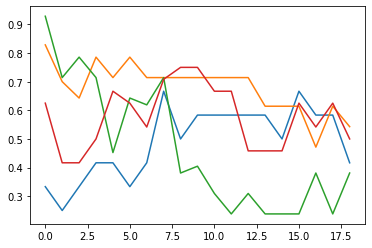

In [205]:
## DataFrame for prediction- pre###
df_pos_pre, df_neg_pre = scoredf('pre')

new_df_lock = pd.DataFrame(columns = ['freq'])
new_df_conversation = pd.DataFrame(columns = ['time'])
#new_df_run = pd.DataFrame(columns = ['percentage'])
new_df_sleep = pd.DataFrame(columns = ['time'])
for uid in df_neg_pre.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    #new_df_run.loc[uid] = df_run.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]

# features = phone_lock, conversation, proportion of time running #
#X = pd.concat([new_df_lock, new_df_conversation, new_df_run], axis = 1)
X = pd.concat([new_df_lock, new_df_conversation, new_df_sleep], axis = 1)

### KNN ####
n_neighbour = roc_auc_comparison(X, df_neg_pre)


KNN(X, df_neg_pre, n_neighbour)


n_neighbour = roc_auc_comparison(X, df_pos_pre)
KNN(X, df_pos_pre, n_neighbour)



## DataFrame for prediction- post###
df_pos_post, df_neg_post = scoredf('post')

new_df_lock = pd.DataFrame(columns = ['freq'])
new_df_conversation = pd.DataFrame(columns = ['time'])
#new_df_run = pd.DataFrame(columns = ['percentage'])
new_df_sleep = pd.DataFrame(columns = ['time'])
for uid in df_neg_post.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]

# features = phone_lock, conversation, proportion of time running #
#X = pd.concat([new_df_lock, new_df_conversation, new_df_run], axis = 1)
X = pd.concat([new_df_lock, new_df_conversation, new_df_sleep], axis = 1)

### KNN ####
print('negative')
n_neighbour = roc_auc_comparison(X, df_neg_post)


KNN(X, df_neg_post, n_neighbour)

print('positive')
n_neighbour = roc_auc_comparison(X, df_pos_post)
KNN(X, df_pos_post, n_neighbour)

In [152]:
logit = linear_model.LogisticRegression(random_state=0, solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X, df_neg_post.to_numpy().ravel(), random_state=42)
logit.fit(X_train, y_train)
pred = logit.predict(X_test)
accuracy_score(y_test, pred)

0.4

2
accuracy: 0.8


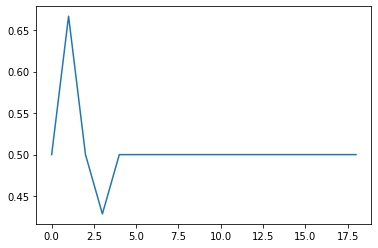

In [240]:
df_total_flour = pd.DataFrame(columns=['total'])

#flour_postscores[0]
for df in flour_postscores:
    if len(df.iloc[:,0]) != 0:
        key = df.iloc[0,0]
        df = df.drop(columns = 'uid')
        df_total_flour.loc[key] = sum(df.to_numpy()[0])
        
#m = df_total_flour.iloc[:, 0].mean()
m=34
df_total_flour[df_total_flour.iloc[:, 0] <= m] = 0
df_total_flour[df_total_flour.iloc[:, 0] > m] = 1 

new_df_lock = pd.DataFrame(columns = ['freq'])
new_df_conversation = pd.DataFrame(columns = ['time'])
new_df_sleep = pd.DataFrame(columns = ['time'])
for uid in df_total_flour.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]
#X = pd.concat([new_df_lock, new_df_conversation, new_df_run], axis = 1)
X = pd.concat([new_df_lock, new_df_conversation, new_df_sleep], axis = 1)


n_neighbour = roc_auc_comparison(X, df_total_flour)
KNN(X, df_total_flour, n_neighbour=2)

In [200]:
# now = datetime.now()
# tomorrow =  now + timedelta(days =1)
# timestamp = datetime.timestamp(now)
# timestamp1 = datetime.timestamp(tomorrow)
# print("timestamp =", timestamp, timestamp1, timestamp1-timestamp)

In [806]:
# features = []
# for key in inputs:
#     features.append(key)
# # features

In [226]:
inputs['bluetooth'][0].

,time,MAC,class_id,level
0,1.364386e+09,68:A3:C4:49:61:9E,4063500.0,-88.0
1,NaN,NaN,NaN,NaN
2,1.364387e+09,00:1E:C2:94:87:2B,3670276.0,-82.0
3,1.364387e+09,40:A6:D9:FB:47:70,3801348.0,-90.0
4,1.364387e+09,40:A6:D9:FB:48:54,3801348.0,-95.0
...,...,...,...,...
8620,NaN,NaN,NaN,NaN
8621,1.370046e+09,F4:CE:46:A1:A5:65,1312384.0,-95.0
8622,NaN,NaN,NaN,NaN
8623,1.370047e+09,F4:CE:46:A1:A5:65,1312384.0,-95.0


In [254]:
df_total_flour
df_pos_post
df_class = pd.DataFrame(columns=['class'])
for uid in df_total_flour.index:
    s1 = int(df_total_flour.loc[uid])
    s2 = int(df_pos_post.loc[uid])
    if s1 is None or s2 is None:
        continue

    # No confidence and Negative
    if s1 == 0 and s2 == 0:
        df_class.loc[uid] = 1
    # confidence and Negative
    if s1 == 1 and s2==0:
        df_class.loc[uid] = 2
    # No confidence and Positive
    if s1 == 0 and s2==1:
        df_class.loc[uid] = 3
    # confidence and Positive
    if s1 == 1 and s2==1:
        df_class.loc[uid] = 4

In [257]:

np.unique(df_class, return_counts=True)

(array([1, 2, 3, 4], dtype=object), array([ 4, 12,  2, 19]))

In [42]:
# # NAN to 0
# df_panas_new = df_panas.fillna(0)
# X_train = pd.concat([new_df_conversation, new_df_lock], axis=1)[0:25]
# Y_train = df_panas_new.iloc[0:25]
# X_test = pd.concat([new_df_conversation, new_df_lock], axis=1)[25:]
# Y_test = df_panas_new.iloc[25:]
# X_train, X_test, y_train, y_test = train_test_split(pd.concat([new_df_conversation, new_df_lock], axis=1), df_panas_new, random_state=42)
# def calculateAUC(matrix_X, matrix_Y):
#     auc = np.zeros(30)
#     for k in range(1, 31):
#         knn = KNeighborsClassifier(n_neighbors=k)
#         knn.fit(X_train, y_train)
#         predictY = knn.predict(matrix_X)
#         print(predictY)
#         print(matrix_Y.to_numpy())
#         auc[k-1] = roc_auc_score(matrix_Y.to_numpy(), predictY)
#     return auc

# #calculateAUC(X_test, Y_test)
# np.asmatrix(Y_test.to_numpy())
# X_train.to_numpy()
# neighbour = KNeighborsClassifier(n_neighbors=9)

# neighbour.fit(X_train, y_train)
# pred = neighbour.predict(X_test)
# y_np = Y_test.to_numpy()
# for i in range(len(pred)):
#     print(accuracy_score(pred[i], y_np[i]))

In [227]:
inputs[''][2].head(50)

,start_timestamp,end_timestamp
0,1.364426e+09,1.364426e+09
1,NaN,NaN
2,1.364428e+09,1.364428e+09
3,NaN,NaN
4,1.364428e+09,1.364428e+09
5,NaN,NaN
6,1.364429e+09,1.364429e+09
7,NaN,NaN
8,1.364429e+09,1.364429e+09
9,NaN,NaN


In [207]:
inputs.keys()

dict_keys(['wifi', 'gps', 'activity', 'phonelock', 'wifi_location', 'audio', 'bluetooth', 'dark', 'phonecharge', 'conversation'])